<h1> Fashion classification </h1>

Data set:

https://www.kaggle.com/datasets/zalando-research/fashionmnist

- Each row is a separate image

- Column 1 is the class label.

- Remaining columns are pixel numbers (784 total).

- Each value is the darkness of the pixel (1 to 255)

<h2> Project goals </h2>

- CLassification of labeled data using known classifiers.

- Practical use of the knowledge of chapters 2, 4, 5, 6 and 7 of the book: Hands-on Machine Learning with Scikit-Learn, Keras, and TensorFlow.

<h3> Note </h3>
In some moments we will use a cells with links to a google colab notebooks. It will let us to did a project with much more computer power, much faster.

<h2> Settings and libraries </h2>

In [2]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, roc_auc_score, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split, GridSearchCV
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support, roc_curve, roc_auc_score
import pickle
from sklearn.svm import LinearSVC, SVC
from sklearn.multiclass import OneVsOneClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier

%run ml_functions.ipynb
%run custom_transformers.ipynb

In [3]:
# import opendatasets as od
# od.download(
#     "https://www.kaggle.com/datasets/zalando-research/fashionmnist")

<h2> First look </h2>

In [4]:
df_train = pd.read_csv("fashionmnist/fashion-mnist_train.csv")
df_test = pd.read_csv("fashionmnist/fashion-mnist_test.csv")

In [5]:
df_train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
print(df_train.shape)
print(df_test.shape)

(60000, 785)
(10000, 785)


Separate class label column.

In [7]:
y_train = df_train["label"]
X_train = df_train.drop("label", axis=1)

y_test = df_test["label"]
X_test = df_test.drop("label", axis=1)

Convert numerical dfs to numpy arrays.

In [8]:
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()

Show sample cloth.

In [9]:
labels = {0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover',
               3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt',
               7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}

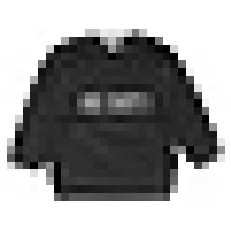

Pullover


In [10]:
pixels_to_image(X_train[0], 28, 28, labels=labels, y=y_train[0])

Check for nans

In [11]:
df_train.isnull().values.any()

False

Check if columns are constant or quasi-constant.

In [12]:
selector = VarianceThreshold(0.01)
selector.fit_transform(df_train)
df_train.shape[1] - sum(selector.get_support())

1

There is only 1 quasi-column for 0.01 threshold.

There is no const. columns.

Labels distribution

In [13]:
df_train["label"].value_counts()

9    6000
8    6000
7    6000
6    6000
5    6000
4    6000
3    6000
2    6000
1    6000
0    6000
Name: label, dtype: int64

Labels are equally distributed.

<h2> Data preprocessing </h2>

In [14]:
X = X_train.copy()

Standarization

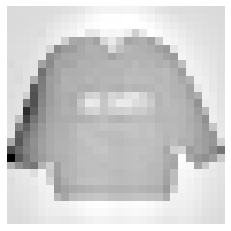

Pullover


In [15]:
X = X_train.copy()

pipeline_scaler = Pipeline([
    ('std_scaler', StandardScaler()),
    ])

X_scaled = pipeline_scaler.fit_transform(X)
pixels_to_image(X_scaled[0], 28, 28, labels=labels, y=y_train[0])

In [16]:
# print('Black = 0 and white > 1:')
# X = X_train.copy()

# pipeline_binary0 = Pipeline([
#     ('pixel_to_binary', PixeltoBinary()),
#     ])

# X_binared0 = pipeline_binary0.fit_transform(X)
# describe_fashion(X_binared0[0], y_train[0])

# np.count_nonzero(X_binared0) / np.product(X_binared0.shape)

# print('On average half of the pixels on an image are not white.'')

In [17]:
#print('Black <= 128 and white > 128:')

# X = X_train.copy()

# pipeline_binary128 = Pipeline([
#     ('pixel_to_binary', PixeltoBinary(floor=128)),
#     ])

# X_binared128 = pipeline_binary128.fit_transform(X)
# describe_fashion(X_binared128[0], y_train[0])

In [17]:
# print('Constant and quasi-constant columns')

# X = X_train.copy()

# columns = np.arange(0, X_train.shape[1], 1)

# pipeline_constant = ColumnTransformer([
#  ("num", DropConstantColumn(threshold=0.01), columns),
#  ])

# X_noconst = pipeline_constant.fit_transform(X)

<h2> Softmax regression classifier </h2>

Now we will use softmax regression classifier usinf sklearn, for prediction.

As we know, it's preferable to have at least a little bit of regularization. Lasso or Elastic Net are a good choices, if we suspect, that only a few features have a big impact. It's not our case. That's why we will try to regularize with a Ridge. Additonally, we will use early stopping.

Let's begin with a plain model.

In [18]:
X_, X_cv, y_, y_cv = train_test_split(X_scaled, y_train, test_size=0.2, random_state=42)

In [36]:
model = LogisticRegression(penalty='none', multi_class='multinomial', fit_intercept=False, max_iter=100)

model.fit(X_, y_)

/home/areczek/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(fit_intercept=False, multi_class='multinomial',
                   penalty='none')

In [64]:
y_cv_pred = cross_val_predict(model, X_cv, y_cv)
y_cv_pred_proba = cross_val_predict(model, X_cv, y_cv, method='predict_proba')

/home/areczek/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/areczek/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model

In [48]:
con = confusion_matrix(y_cv, y_cv_pred)

In [49]:
fashion = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

pd.DataFrame(con, index=fashion, columns=fashion)

,T-shirt/top,Trouser,Pullover,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Ankle boot
T-shirt/top,932,12,36,50,10,6,172,2,12,0
Trouser,8,1113,6,30,7,0,8,1,1,0
Pullover,22,7,844,19,147,3,149,0,8,1
Dress,47,47,30,1003,58,1,49,1,3,3
Coat,9,4,151,57,803,2,150,0,9,0
Sandal,1,1,1,1,0,1007,0,77,16,37
Shirt,191,6,165,45,126,2,683,0,24,1
Sneaker,0,0,0,0,0,67,0,1108,2,47
Bag,10,4,10,9,6,19,29,9,1048,5
Ankle boot,0,0,0,0,0,30,1,52,2,1125


As we can see our model is often wrong, when predicting T-shirt/Top, Pullover, Coat and Shirt, which are intuitively most similar parts of clothing.

Let's measure precision, recall and F1 score.

In [53]:
precision, recall, f1_score = precision_recall_fscore_support(y_cv, y_cv_pred)[:3]

In [56]:
np.average(precision), np.average(recall), np.average(f1_score)

(0.8072198150520127, 0.8072187825077579, 0.8071471966564465)

Generally, F1 favors classifiers which have similar precision and recall, and this is what we want in our case, so it will be our performance measure and there is no need to experiment with precision/recall tradeoff. Additionally, F1 score is preffered for multiclass classification over ROC AUC.

<h3> Hyperparameter tuning </h3>

In [70]:
model = LogisticRegression(multi_class='multinomial', max_iter=400, random_state=42, penalty='l2')

parameters = {'C': [10, 1, 0.1, 0.01, 0.001],
              'solver': ['newton-cg', 'lbfgs', 'sag', 'saga']}

model = GridSearchCV(model, parameters)

model.fit(X_, y_)

/home/areczek/anaconda3/lib/python3.7/site-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/home/areczek/anaconda3/lib/python3.7/site-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/home/areczek/anaconda3/lib/python3.7/site-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/home/areczek/anaconda3/lib/python3.7/site-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/home/areczek/anaconda3/lib/python3.7/site-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increas

GridSearchCV(estimator=LogisticRegression(max_iter=400,
                                          multi_class='multinomial',
                                          random_state=42),
             param_grid={'C': [10, 1, 0.1, 0.01, 0.001],
                         'solver': ['newton-cg', 'lbfgs', 'sag', 'saga']})

Even if we set max_features hyperparameter to 1000, max_iter is reached for the models that warnings refer to, what I check on Google Colab:

https://colab.research.google.com/drive/1hB2aPWlFX2shlonTnbtdNvft4jGQ9FQp?usp=sharing

Let's check model of which parameters was best and tune again.

In [75]:
model.best_params_

{'C': 0.01, 'solver': 'newton-cg'}

In [24]:
model = LogisticRegression(multi_class='multinomial', max_iter=400, random_state=42, penalty='l2', solver='newton-cg')

parameters = {'C': [0.003, 0.005, 0.01, 0.03, 0.05] }

model = GridSearchCV(model, parameters)

model.fit(X_, y_)

GridSearchCV(estimator=LogisticRegression(max_iter=400,
                                          multi_class='multinomial',
                                          random_state=42, solver='newton-cg'),
             param_grid={'C': [0.003, 0.005, 0.01, 0.03, 0.05]})

In [25]:
model.best_params_

{'C': 0.01}

As we can see a best finded model is for newton-cg solver and C=0.01.

Now, save the model.

In [27]:
model = model.best_estimator_

In [24]:
filename = 'models/LogisticRegression1.sav'
pickle.dump(model, open(filename, 'wb'))

Let's make some predictions.

In [29]:
y_cv_pred = cross_val_predict(model, X_cv, y_cv)
y_cv_pred_proba = cross_val_predict(model, X_cv, y_cv, method='predict_proba')

In [33]:
precision, recall, f1_score = precision_recall_fscore_support(y_cv, y_cv_pred)[:3]

In [34]:
np.average(precision), np.average(recall), np.average(f1_score)

(0.8427606975984322, 0.8434101913763603, 0.8428416182741575)

As we can see with a pretty similar values of precision and recall f1_score equals around 0.84. It's better than before (f1_score was equal around 0.81).

It's time for error analysis.

In [35]:
con = confusion_matrix(y_cv, y_cv_pred)

fashion = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

pd.DataFrame(con, index=fashion, columns=fashion)

,T-shirt/top,Trouser,Pullover,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Ankle boot
T-shirt/top,1009,6,16,57,3,5,125,0,11,0
Trouser,6,1116,9,35,3,0,5,0,0,0
Pullover,14,2,892,11,157,0,117,0,7,0
Dress,44,14,13,1088,48,0,32,0,3,0
Coat,3,4,116,49,893,0,115,0,5,0
Sandal,2,0,1,2,0,1033,0,70,9,24
Shirt,194,4,135,41,129,2,718,0,19,1
Sneaker,0,0,0,0,0,56,0,1130,0,38
Bag,8,1,5,10,2,8,26,7,1080,2
Ankle boot,0,1,0,0,0,20,1,43,1,1144


At first glance, errors of recognizing clothes are the same type as before. It's time to use matshow function.

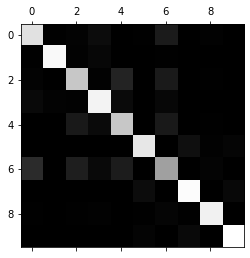

In [37]:
plt.matshow(con, cmap=plt.cm.gray)
plt.show()

Most of instances were classified correctly, that's why main diagonal is bright. However indexes 0,2,4 and 6 are darker than others. It could mean that, there are fewer images of this kind or classifier doesn't perform that good for these clothes. As we know labels are quite good balanced, also the dataset opts for the second idea.

Let's focus our plot on errors. We will replace pure number with ratios (divide each value by number of instances of corresponding class) and set 0 for diagonal.

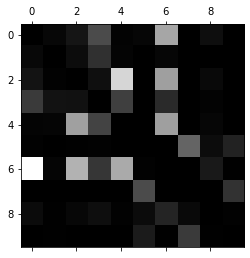

In [39]:
row_sums = con.sum(axis=1, keepdims=True)
normalized_con = con / row_sums

np.fill_diagonal(normalized_con, 0)
plt.matshow(normalized_con, cmap=plt.cm.gray)
plt.show()

Columns with index 4 and 6 are quire bright, which means many of instances get missclassified as Coat or Shirt. Also rows of these clothes are bright. This time, it means that Shirts and Coats are sometimes classified wrong.
As we can see, the biggest error is because of the situation that Shirts are predicted as T-shirts / Tops.
The reason of these errors is a high similarity of these clothes.

Now, our idea is to analyze these errors to gain insights why exactly our classifier makes these wrong predictions. After that, we will consider what kind of transformations or additional features may help to imporve predictions.

Let's start by displaying confusion matrices for those highlighted classes in OvO way.

In [61]:
filename = 'models/LogisticRegression1.sav'
model = pickle.load(open(filename, 'rb'))
print(model)

LogisticRegression(C=0.01, max_iter=400, multi_class='multinomial',
                   random_state=42, solver='newton-cg')


In [62]:
y_pred = model.predict(X_)

T-shirt/Top vs Shirt

[False False False ... False False  True]


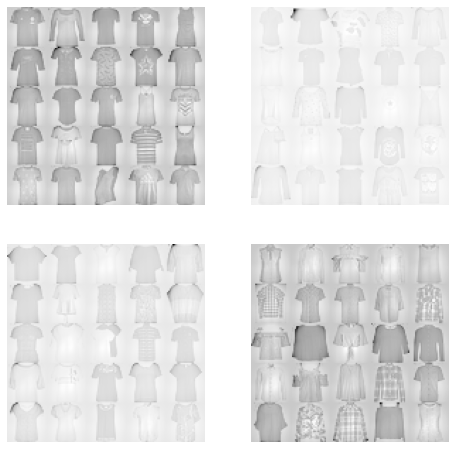

In [75]:
cl_a, cl_b = 0, 6
X_aa = X_[(y_ == cl_a) & (y_pred == cl_a)]
X_ab = X_[(y_ == cl_a) & (y_pred == cl_b)]
X_ba = X_[(y_ == cl_b) & (y_pred == cl_a)]
X_bb = X_[(y_ == cl_b) & (y_pred == cl_b)]
plt.figure(figsize=(8,8))
print((y_ == cl_a))
plt.subplot(221); plot_image_class(X_aa[:25], images_per_row=5, im_height=28, im_width=28)
plt.subplot(222); plot_image_class(X_ab[:25], images_per_row=5, im_height=28, im_width=28)
plt.subplot(223); plot_image_class(X_ba[:25], images_per_row=5, im_height=28, im_width=28)
plt.subplot(224); plot_image_class(X_bb[:25], images_per_row=5, im_height=28, im_width=28)
plt.savefig(fname='plots/TshirtTopVSShirt')
plt.show()

Thanks to this image we can get some conclusions.

Generally shirts are long-sleeved and sometimes short-sleeved but more formal than T-shirts or tops. We could predict some of shirts by long-sleeved description, however there are some instances of tops that their images are with mannequin body, which may get an impression that these are shirts. Nevertheless, we can tell our model to look at some pixels around shoulders to detect if a particular cloth is a shirt or a top. [ long-sleeved + shoulders ]

Pullover vs Shirt

[False False False ... False False False]


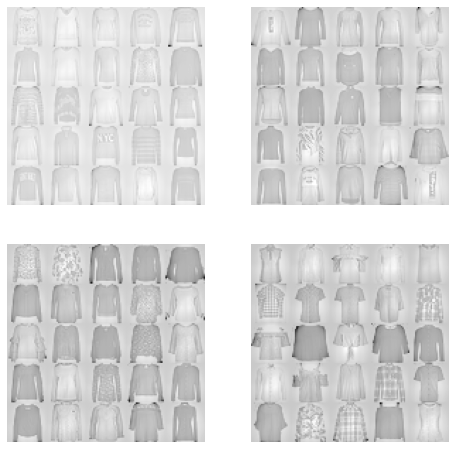

In [71]:
cl_a, cl_b = 2, 6
X_aa = X_[(y_ == cl_a) & (y_pred == cl_a)]
X_ab = X_[(y_ == cl_a) & (y_pred == cl_b)]
X_ba = X_[(y_ == cl_b) & (y_pred == cl_a)]
X_bb = X_[(y_ == cl_b) & (y_pred == cl_b)]
plt.figure(figsize=(8,8))
print((y_ == cl_a))
plt.subplot(221); plot_image_class(X_aa[:25], images_per_row=5, im_height=28, im_width=28)
plt.subplot(222); plot_image_class(X_ab[:25], images_per_row=5, im_height=28, im_width=28)
plt.subplot(223); plot_image_class(X_ba[:25], images_per_row=5, im_height=28, im_width=28)
plt.subplot(224); plot_image_class(X_bb[:25], images_per_row=5, im_height=28, im_width=28)
plt.savefig(fname='plots/PulloverVSShirt')
plt.show()

This time, we can see that some of the shirts was predicted this time as pullovers, but some of them has decorative sleeves, deviating from the typical shape, which may change some of the wrong predictions.

Additionally, it looks like some of the pullovers has different colour material on the sleeves, which could have been confusing for the model.

Coat vs Shirt

[False False False ... False  True False]


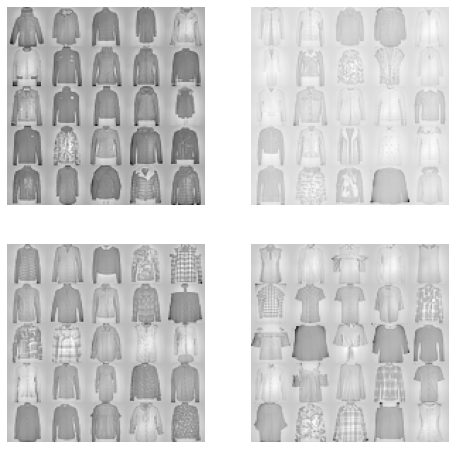

In [57]:
cl_a, cl_b = 4, 6
X_aa = X_[(y_ == cl_a) & (y_pred == cl_a)]
X_ab = X_[(y_ == cl_a) & (y_pred == cl_b)]
X_ba = X_[(y_ == cl_b) & (y_pred == cl_a)]
X_bb = X_[(y_ == cl_b) & (y_pred == cl_b)]
plt.figure(figsize=(8,8))
print((y_ == cl_a))
plt.subplot(221); plot_image_class(X_aa[:25], images_per_row=5, im_height=28, im_width=28)
plt.subplot(222); plot_image_class(X_ab[:25], images_per_row=5, im_height=28, im_width=28)
plt.subplot(223); plot_image_class(X_ba[:25], images_per_row=5, im_height=28, im_width=28)
plt.subplot(224); plot_image_class(X_bb[:25], images_per_row=5, im_height=28, im_width=28)
plt.savefig(fname='plots/CoatVSShirt')
plt.show()

This time, it looks like an averege level of bright counts the most there. Well predicted coats are darker than real shirts. Coats classified as shirts are brighter as usual, and shirts classified as coats are generally darker than a real shirts.

Pullover vs Shirt

[False False False ... False False False]


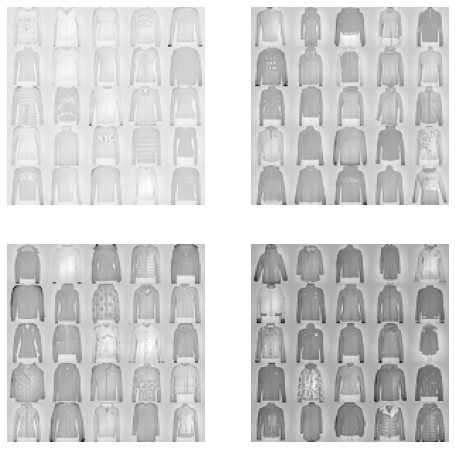

In [60]:
cl_a, cl_b = 2, 4
X_aa = X_[(y_ == cl_a) & (y_pred == cl_a)]
X_ab = X_[(y_ == cl_a) & (y_pred == cl_b)]
X_ba = X_[(y_ == cl_b) & (y_pred == cl_a)]
X_bb = X_[(y_ == cl_b) & (y_pred == cl_b)]
plt.figure(figsize=(8,8))
print((y_ == cl_a))
plt.subplot(221); plot_image_class(X_aa[:25], images_per_row=5, im_height=28, im_width=28)
plt.subplot(222); plot_image_class(X_ab[:25], images_per_row=5, im_height=28, im_width=28)
plt.subplot(223); plot_image_class(X_ba[:25], images_per_row=5, im_height=28, im_width=28)
plt.subplot(224); plot_image_class(X_bb[:25], images_per_row=5, im_height=28, im_width=28)
plt.savefig(fname='plots/PulloverVSCoat')
plt.show()

Generally coats torso is wider than pullovers. However, some of the clothes don't look like uni-sex type (some outliers aren't that wide). Also, it looks like coats sleeves are wider and shorter in relation to torsos wide, in opposite to pullovers sleeves.

###  Additional features and transformations ...

<h2> Support Vector Machines </h2>

<h3> Linear Kernel </h3>

Let's try a linear kernel first (since it's faster to train than other kernels and pretty often gives a good solutions), using LinearSVC from sklearn (SVC with linear kernel is just slower).

Now, train a model with a common setting, and make some predictions.

In [17]:
model = LinearSVC(C=1, loss='squared_hinge', dual=False)

model.fit(X_, y_)

/home/areczek/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1, dual=False)

In [ ]:
y_cv_pred = cross_val_predict(model, X_cv, y_cv)

In [19]:
con = confusion_matrix(y_cv, y_cv_pred)

fashion = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

pd.DataFrame(con, index=fashion, columns=fashion)

,T-shirt/top,Trouser,Pullover,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Ankle boot
T-shirt/top,922,17,35,68,19,11,129,6,23,2
Trouser,5,1107,7,39,5,1,7,2,1,0
Pullover,24,15,849,16,153,6,110,8,12,7
Dress,57,41,22,988,51,3,61,6,10,3
Coat,16,10,133,59,816,5,129,6,11,0
Sandal,6,5,2,9,3,944,10,91,24,47
Shirt,179,11,152,64,139,14,637,7,35,5
Sneaker,1,5,0,5,0,66,3,1086,8,50
Bag,27,5,19,26,15,29,29,20,967,12
Ankle boot,3,2,1,0,0,28,6,58,2,1110


In [20]:
precision, recall, f1_score = precision_recall_fscore_support(y_cv, y_cv_pred)[:3]

np.average(precision), np.average(recall), np.average(f1_score)

(0.7848898534530159, 0.786893144708968, 0.7855519884574018)

For sure, the model can perform better. It's time for hyperparameter tuning.

<h4> Hyperparameter tuning </h4>

https://colab.research.google.com/drive/1hB2aPWlFX2shlonTnbtdNvft4jGQ9FQp?usp=sharing

In [32]:
filename = 'models/LinearSVC1.sav'
loaded_model = pickle.load(open(filename, 'rb'))
print(loaded_model)

LinearSVC(C=0.01, dual=False, max_iter=1500, random_state=42)


In [34]:
model=loaded_model

y_cv_pred = cross_val_predict(model, X_cv, y_cv)

In [35]:
precision, recall, f1_score = precision_recall_fscore_support(y_cv, y_cv_pred)[:3]
np.average(precision), np.average(recall), np.average(f1_score)

(0.8227614784352264, 0.8248811008414083, 0.8232872801014098)

Results are worser than for Softmax (LogisticRegression).

In [36]:
con = confusion_matrix(y_cv, y_cv_pred)

fashion = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

pd.DataFrame(con, index=fashion, columns=fashion)

,T-shirt/top,Trouser,Pullover,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Ankle boot
T-shirt/top,994,6,23,60,9,8,113,2,17,0
Trouser,5,1117,7,37,3,0,3,1,1,0
Pullover,24,4,890,16,163,3,90,1,9,0
Dress,48,16,17,1059,48,8,37,3,5,1
Coat,7,8,113,59,855,4,127,1,11,0
Sandal,2,2,2,7,1,992,2,82,10,41
Shirt,210,7,149,49,125,9,664,2,27,1
Sneaker,0,0,0,2,0,57,0,1121,2,42
Bag,12,0,10,13,8,20,21,9,1052,4
Ankle boot,0,0,1,1,0,23,2,46,0,1137


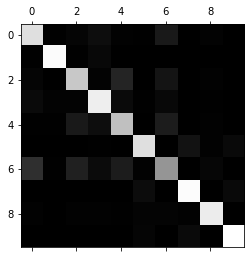

In [37]:
plt.matshow(con, cmap=plt.cm.gray)
plt.show()

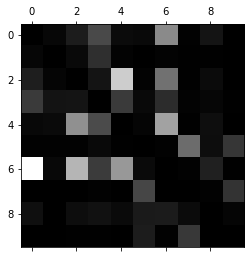

In [38]:
row_sums = con.sum(axis=1, keepdims=True)
normalized_con = con / row_sums

np.fill_diagonal(normalized_con, 0)
plt.matshow(normalized_con, cmap=plt.cm.gray)
plt.show()

It looks like LinearSVC and Softmax mislead the same classes. There is a chance that reasons of the errors are different , but let's just not focus on it now.

<h3> RBF kernel </h3>

Let's try a SVC with rbf kernel, which is a common choice after a linear kernel, when a training set is not too large.

A plain model first.

In [51]:
model = SVC(kernel='rbf', gamma=5, C=0.001, decision_function_shape='ovo')
model.fit(X_, y_)

SVC(C=0.001, decision_function_shape='ovo', gamma=5)

In [52]:
y_cv_pred = cross_val_predict(model, X_cv, y_cv)

In [53]:
con = confusion_matrix(y_cv, y_cv_pred)

fashion = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

pd.DataFrame(con, index=fashion, columns=fashion)

,T-shirt/top,Trouser,Pullover,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Ankle boot
T-shirt/top,0,0,0,246,0,0,986,0,0,0
Trouser,0,0,0,235,0,0,939,0,0,0
Pullover,0,0,0,240,0,0,960,0,0,0
Dress,0,0,0,248,0,0,994,0,0,0
Coat,0,0,0,237,0,0,948,0,0,0
Sandal,0,0,0,228,0,0,913,0,0,0
Shirt,0,0,0,249,0,0,994,0,0,0
Sneaker,0,0,0,245,0,0,979,0,0,0
Bag,0,0,0,230,0,0,919,0,0,0
Ankle boot,0,0,0,242,0,0,968,0,0,0


In [54]:
precision, recall, f1_score = precision_recall_fscore_support(y_cv, y_cv_pred)[:3]

np.average(precision), np.average(recall), np.average(f1_score)

/home/areczek/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.0206875, 0.09993561367166601, 0.03195330001570516)

The model definitely needs hyperparameter tuning.

<h4> Hyperparameter tuning </h4>

https://colab.research.google.com/drive/1hB2aPWlFX2shlonTnbtdNvft4jGQ9FQp?usp=sharing

<h2> DecisionTree </h2>
It's another pretty powerful algorithm, capable of fitting complex datasets. We will try it in two versions - a normal Decision Tree and an Extra Tree, trading more bias for a lower variance. Our training plan will be similar to the previous ones.
<h3> DecisionTreeClassifier </h3>

In [55]:
model = DecisionTreeClassifier()
model.n_classes = 10
model.fit(X_, y_)

DecisionTreeClassifier()

In [56]:
y_cv_pred = cross_val_predict(model, X_cv, y_cv)
y_cv_pred_proba = cross_val_predict(model, X_cv, y_cv, method='predict_proba')

In [57]:
con = confusion_matrix(y_cv, y_cv_pred)

fashion = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

pd.DataFrame(con, index=fashion, columns=fashion)

,T-shirt/top,Trouser,Pullover,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Ankle boot
T-shirt/top,884,14,27,67,11,6,205,2,14,2
Trouser,14,1072,5,55,10,3,10,2,3,0
Pullover,37,4,776,16,161,3,178,1,20,4
Dress,62,49,32,954,70,8,50,0,16,1
Coat,13,4,190,87,703,1,160,1,22,4
Sandal,4,2,0,8,2,969,4,93,18,41
Shirt,199,12,171,45,137,8,646,1,22,2
Sneaker,0,0,0,1,0,93,0,1024,9,97
Bag,18,5,14,12,17,17,35,18,1000,13
Ankle boot,1,0,1,3,1,34,0,113,10,1047


In [58]:
precision, recall, f1_score = precision_recall_fscore_support(y_cv, y_cv_pred)[:3]

np.average(precision), np.average(recall), np.average(f1_score)

(0.7587264396325681, 0.7579859568315701, 0.7582557530739633)

<h4> Hyperparameter Tuning </h4>

In [28]:
model = DecisionTreeClassifier(random_state=42, max_leaf_nodes=None)

parameters = {'max_depth': [5, 9, 13, 17, 21],
              'min_samples_split': [5, 11, 17, 23, 29],
              'min_samples_leaf': [1, 3, 5, 7, 9],
              'max_features': ['auto', 'sqrt', 'log2', None]
             }

model = GridSearchCV(model, parameters)

model.fit(X_, y_)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': [5, 9, 13, 17, 21],
                         'max_features': ['auto', 'sqrt', 'log2', None],
                         'min_samples_leaf': [1, 3, 5, 7, 9],
                         'min_samples_split': [5, 11, 17, 23, 29]})

In [29]:
model.best_params_

{'max_depth': 13,
 'max_features': None,
 'min_samples_leaf': 9,
 'min_samples_split': 5}

In [30]:
model = DecisionTreeClassifier(random_state=42, max_leaf_nodes=None, max_features=None)

parameters = {'max_depth': [11, 12, 13, 14, 15],
              'min_samples_split': [2, 3, 4, 5, 6, 7, 8],
              'min_samples_leaf': [8, 9, 10, 11, 12]
             }

model = GridSearchCV(model, parameters)

model.fit(X_, y_)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': [11, 12, 13, 14, 15],
                         'min_samples_leaf': [8, 9, 10, 11, 12],
                         'min_samples_split': [2, 3, 4, 5, 6, 7, 8]})

In [31]:
model.best_params_

{'max_depth': 13, 'min_samples_leaf': 9, 'min_samples_split': 2}

In [36]:
model = DecisionTreeClassifier(random_state=42, max_leaf_nodes=None, max_features=None, max_depth=13, min_samples_leaf=9, min_samples_split=2)

model.fit(X_, y_)

DecisionTreeClassifier(max_depth=13, min_samples_leaf=9, random_state=42)

In [37]:
filename = 'models/DecisionTree1.sav'
pickle.dump(model, open(filename, 'wb'))

In [76]:
filename = 'models/DecisionTree1.sav'
loaded_model = pickle.load(open(filename, 'rb'))
print(loaded_model)
print(type(loaded_model))

DecisionTreeClassifier(max_depth=13, min_samples_leaf=9, random_state=42)
<class 'sklearn.linear_model._logistic.LogisticRegression'>


In [39]:
model=loaded_model

y_cv_pred = cross_val_predict(model, X_cv, y_cv)

In [40]:
precision, recall, f1_score = precision_recall_fscore_support(y_cv, y_cv_pred)[:3]
np.average(precision), np.average(recall), np.average(f1_score)

(0.7725931653278766, 0.7734524717306759, 0.7726369581739622)

In [ ]:
...

<h3> ExtraTreeClassifier </h3>

In [66]:
model = ExtraTreeClassifier()
model.n_classes = 10
model.fit(X_, y_)

ExtraTreeClassifier()

In [67]:
y_cv_pred = cross_val_predict(model, X_cv, y_cv)
y_cv_pred_proba = cross_val_predict(model, X_cv, y_cv, method='predict_proba')

In [68]:
con = confusion_matrix(y_cv, y_cv_pred)

fashion = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

pd.DataFrame(con, index=fashion, columns=fashion)

,T-shirt/top,Trouser,Pullover,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Ankle boot
T-shirt/top,836,15,31,86,20,2,225,1,16,0
Trouser,13,1065,4,59,9,1,18,0,4,1
Pullover,33,11,732,23,193,7,182,0,16,3
Dress,87,65,22,890,90,8,65,0,13,2
Coat,31,17,231,73,644,3,164,0,22,0
Sandal,2,5,1,17,1,866,3,163,22,61
Shirt,199,15,207,67,182,1,534,1,36,1
Sneaker,0,0,0,0,0,131,2,997,3,91
Bag,18,7,30,15,21,28,41,15,962,12
Ankle boot,0,0,4,3,2,63,1,95,13,1029


In [69]:
precision, recall, f1_score = precision_recall_fscore_support(y_cv, y_cv_pred)[:3]

np.average(precision), np.average(recall), np.average(f1_score)

(0.715226254220023, 0.7146567150703842, 0.7148092068675478)

<h4> Hyperparameter tuning </h4>

https://colab.research.google.com/drive/1HQY7CHHsvjUBlmSUQItnXDUUaQK9veOI?usp=sharing

<h2> Ensemble methods </h2>

<h3> Random Forest </h3>

In [72]:
model = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16)
model.n_classes = 10
model.fit(X_, y_)

RandomForestClassifier(max_leaf_nodes=16, n_estimators=500)

In [73]:
y_cv_pred = cross_val_predict(model, X_cv, y_cv)
y_cv_pred_proba = cross_val_predict(model, X_cv, y_cv, method='predict_proba')

In [74]:
con = confusion_matrix(y_cv, y_cv_pred)

fashion = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

pd.DataFrame(con, index=fashion, columns=fashion)

,T-shirt/top,Trouser,Pullover,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Ankle boot
T-shirt/top,985,6,48,158,5,2,5,0,23,0
Trouser,3,1002,22,144,1,0,2,0,0,0
Pullover,7,3,859,16,290,0,3,0,22,0
Dress,34,8,46,1121,23,0,3,0,7,0
Coat,6,3,162,163,839,0,2,0,10,0
Sandal,1,2,0,5,0,948,0,115,12,58
Shirt,294,4,260,111,434,3,93,0,44,0
Sneaker,0,0,0,0,0,30,0,1102,2,90
Bag,5,3,28,20,2,12,2,3,1074,0
Ankle boot,1,0,0,0,0,9,0,80,4,1116


In [75]:
precision, recall, f1_score = precision_recall_fscore_support(y_cv, y_cv_pred)[:3]

np.average(precision), np.average(recall), np.average(f1_score)

(0.7900072999947861, 0.764246783474106, 0.7398616090306089)

<h4> Hyperparameter tuning </h4>

https://colab.research.google.com/drive/1prFLdTFBYmInMmmb_pg8B-VaHp-_6Uvx?usp=sharing

<h3> ExtraTreesClassifier </h3>

In [78]:
model = ExtraTreesClassifier()
model.n_classes = 10
model.fit(X_, y_)

ExtraTreesClassifier()

In [79]:
y_cv_pred = cross_val_predict(model, X_cv, y_cv)
y_cv_pred_proba = cross_val_predict(model, X_cv, y_cv, method='predict_proba')

In [80]:
con = confusion_matrix(y_cv, y_cv_pred)

fashion = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

pd.DataFrame(con, index=fashion, columns=fashion)

,T-shirt/top,Trouser,Pullover,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Ankle boot
T-shirt/top,1046,2,15,55,7,1,96,0,10,0
Trouser,6,1109,11,44,1,0,3,0,0,0
Pullover,6,0,956,16,141,0,72,0,9,0
Dress,30,3,9,1119,45,0,32,0,4,0
Coat,6,2,120,62,914,0,73,0,8,0
Sandal,0,0,0,0,0,1064,0,53,3,21
Shirt,230,1,168,39,124,1,657,0,23,0
Sneaker,0,0,0,0,0,32,0,1130,3,59
Bag,2,0,5,6,4,5,10,2,1114,1
Ankle boot,0,0,0,0,0,16,0,45,2,1147


In [81]:
precision, recall, f1_score = precision_recall_fscore_support(y_cv, y_cv_pred)[:3]

np.average(precision), np.average(recall), np.average(f1_score)

(0.854773773810507, 0.8564351073049263, 0.8540034105191369)

<h4> Hyperparameter tuning </h4>

https://colab.research.google.com/drive/1bhFs6IwjQm2sfqCvXpbR_vItRPbWC48C?usp=sharing

In [19]:
filename = 'models/ExtraTreesClassifier1.sav'
model = pickle.load(open(filename, 'rb'))
print(model)

ExtraTreesClassifier(max_depth=32, max_features='sqrt', min_samples_leaf=2,
                     n_estimators=132, random_state=42)


In [20]:
y_cv_pred = cross_val_predict(model, X_cv, y_cv)
y_cv_pred_proba = cross_val_predict(model, X_cv, y_cv, method='predict_proba')

In [21]:
con = confusion_matrix(y_cv, y_cv_pred)

fashion = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

pd.DataFrame(con, index=fashion, columns=fashion)

,T-shirt/top,Trouser,Pullover,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Ankle boot
T-shirt/top,1064,1,11,59,5,2,79,0,11,0
Trouser,6,1110,9,44,2,0,3,0,0,0
Pullover,4,1,954,17,142,0,71,0,11,0
Dress,32,1,10,1126,42,0,28,0,3,0
Coat,4,2,114,72,908,0,79,0,6,0
Sandal,0,0,0,0,0,1056,0,55,5,25
Shirt,235,2,174,44,125,2,636,0,25,0
Sneaker,0,0,0,0,0,30,0,1132,2,60
Bag,3,0,3,5,4,4,15,2,1113,0
Ankle boot,0,0,0,0,0,16,0,46,1,1147


In [22]:
precision, recall, f1_score = precision_recall_fscore_support(y_cv, y_cv_pred)[:3]

np.average(precision), np.average(recall), np.average(f1_score)

(0.8537116655395247, 0.8555577026043129, 0.8526360623548905)

One of the advantages of a RandomForests is that they are able to specify feature importances. Let's plot them in our case.

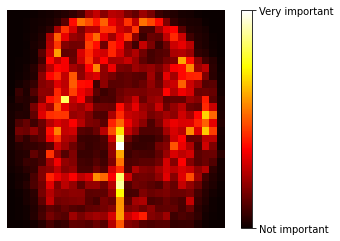

In [33]:
image = model.feature_importances_.reshape(28, 28)
plt.imshow(image, cmap = mpl.cm.hot,
           interpolation="nearest")
plt.axis("off")

cbar = plt.colorbar(ticks=[model.feature_importances_.min(), model.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

plt.show()

As we can see, there are a few useless pixels in every corner. We can easily drop the features doing second series of model training.

<h3> AdaBoostClassifier </h3>

In [ ]:
...

<h3> Gradient Boosting </h3>

In [ ]:
...

<h3> Other Ensembles </h3>